<a href="https://www.kaggle.com/code/ilya2ko/project-3-eda-predict-rating-hotels?scriptVersionId=139809333" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Загрузка библиотек и данных

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [8]:
#df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv('submission.csv') # самбмишн

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test,df_train], axis=0).reset_index(drop=True) # объединяем
data.tail(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2
515737,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208,1,8.8


## Предварительный анализ

In [9]:
data['hotel_name'].nunique()

1492

In [10]:
data['review_date'] = pd.to_datetime(data['review_date'])

## Работа с тегами - создадим из строки тегов признак списков тегов

In [11]:
n_hotels = data.copy()

def rev_func(num_tags):
    # Преобразуем строку тегов в списки тегов
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

n_hotels['tags_n'] = n_hotels['tags'].apply(rev_func)
n_hotels['tags_n'][0]

['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights']

#### Выявим только популярные теги 

**explode()** - Эта функция используется для преобразования столбца списков или массивов в несколько строк, с одной строкой для каждого элемента в списке или массиве

In [12]:
# отберем популярные теги
explode= n_hotels.explode('tags_n')

tags = explode['tags_n'].value_counts() 
top_tag = tags[tags > 900]
top_tag_l = list(top_tag.index)

print('Всего униакльных тегов: ',explode['tags_n'].nunique(), 
      'Оставляем теги: ',len(top_tag_l),
      sep='\n')

Всего униакльных тегов: 
2428
Оставляем теги: 
96


### Для определения важности тегов, построим корреляцию

#### Построим корреляцию между тегами и признакми оценок

In [13]:
explode_tags = explode[['tags_n','reviewer_score','average_score']]

Таблица со всеми тегами

In [14]:
explode_tags

,tags_n,reviewer_score,average_score
0,Leisure trip,0.0,8.1
0,Couple,0.0,8.1
0,Double Room,0.0,8.1
0,Stayed 2 nights,0.0,8.1
1,Leisure trip,0.0,8.6
...,...,...,...
515736,Stayed 2 nights,9.2,8.1
515737,Leisure trip,8.8,9.0
515737,Couple,8.8,9.0
515737,Bunk Bed Room,8.8,9.0


# Работа с тегами. Таблица с популярными тегами

In [15]:
top_tag = top_tag.reset_index()
top_tag.rename(columns={'tags_n':'count',
                        'index':'tags_n'},inplace=True) 
top_tag

,tags_n,count
0,Leisure trip,417778
1,Submitted from a mobile device,307640
2,Couple,252294
3,Stayed 1 night,193645
4,Stayed 2 nights,133937
...,...,...
91,Superior Double or Twin Room 1 2 Adults,971
92,Twin Hilton Guest Room,951
93,Family Room 2 Adults 2 Children,926
94,Studio King Family,925


#### Объединим таблицы и получим таблицу только с популярными тегами и их оценками

In [16]:
result = explode_tags.join(top_tag,
                           how = 'right',
                           rsuffix='_top')
result.head(3)

,tags_n,reviewer_score,average_score,tags_n_top,count
0,Leisure trip,0.0,8.1,Leisure trip,417778
0,Couple,0.0,8.1,Leisure trip,417778
0,Double Room,0.0,8.1,Leisure trip,417778


Удалим ненужные столбцы

In [17]:
result = result.drop('tags_n_top',axis=1)
result

,tags_n,reviewer_score,average_score,count
0,Leisure trip,0.0,8.1,417778
0,Couple,0.0,8.1,417778
0,Double Room,0.0,8.1,417778
0,Stayed 2 nights,0.0,8.1,417778
1,Leisure trip,0.0,8.6,307640
...,...,...,...,...
95,Leisure trip,0.0,8.3,913
95,Travelers with friends,0.0,8.3,913
95,Deluxe Twin Room Annex,0.0,8.3,913
95,Stayed 3 nights,0.0,8.3,913


Построим график корреляции

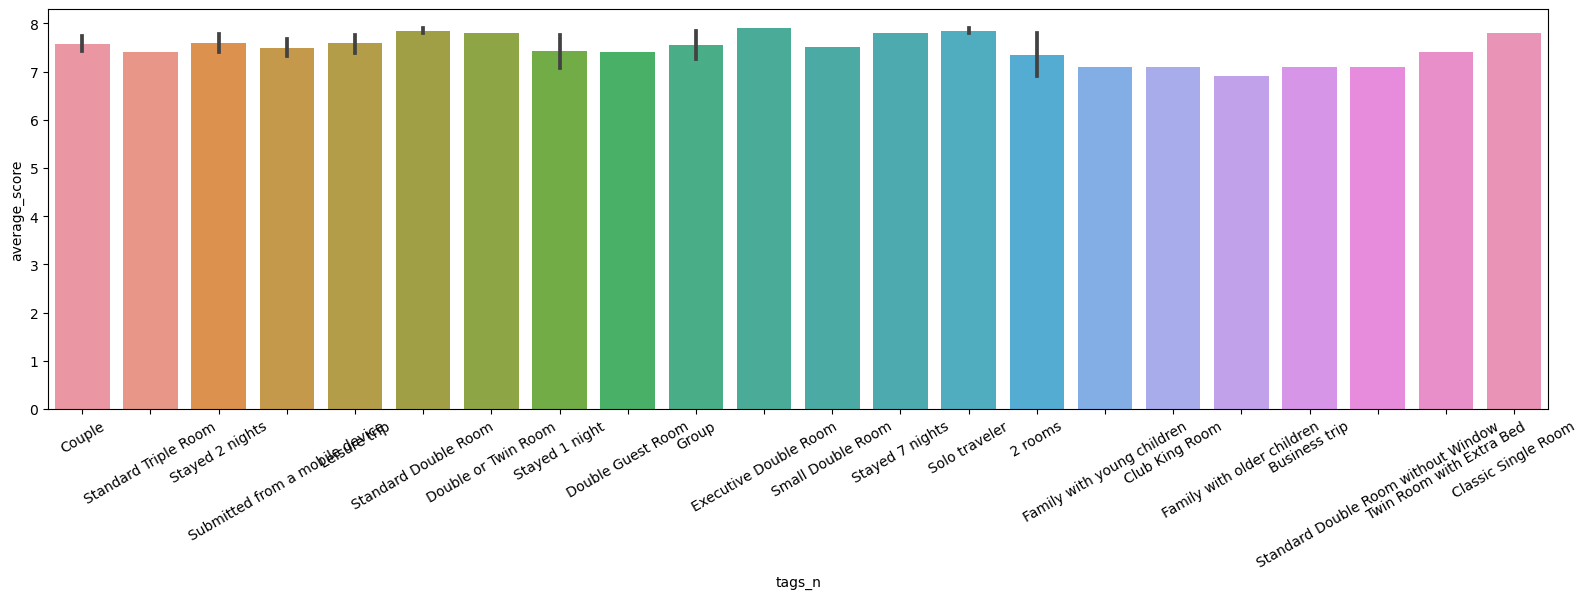

In [18]:
low = result[result['average_score'] <8]

fig = plt.figure(figsize=(15,4))
ax = fig.add_axes([0,0,1,1])

plot = sns.barplot(data=low,
            x= 'tags_n',
            y= 'average_score')
plt.xticks(rotation=30);

Теги "семья с ребенком" имеют средний рейтинг ниже остальных

In [19]:
result

,tags_n,reviewer_score,average_score,count
0,Leisure trip,0.0,8.1,417778
0,Couple,0.0,8.1,417778
0,Double Room,0.0,8.1,417778
0,Stayed 2 nights,0.0,8.1,417778
1,Leisure trip,0.0,8.6,307640
...,...,...,...,...
95,Leisure trip,0.0,8.3,913
95,Travelers with friends,0.0,8.3,913
95,Deluxe Twin Room Annex,0.0,8.3,913
95,Stayed 3 nights,0.0,8.3,913


#### Создадим признаки по каждому популярному тегу,  это пригодится для обучения модели

In [21]:
for tag in list(top_tag['tags_n']):
    n_hotels[tag] = n_hotels['tags_n'].apply(lambda x: 1 if tag in x else 0)

#### Обновляем признак tags_n, оставляя только популярные теги

## Работа с признаком Даты

Создадим признак года

In [22]:
# выведем уникальные года
years = n_hotels['review_date'].dt.year.value_counts()
years = list(years.index)
print(years)

n_hotels['year'] = n_hotels['review_date'].apply(lambda x: x.year)
display(n_hotels['year'].head())

[2016, 2017, 2015]


/tmp/ipykernel_32/15465462.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n_hotels['year'] = n_hotels['review_date'].apply(lambda x: x.year)


0    2017
1    2016
2    2015
3    2015
4    2016
Name: year, dtype: int64

Создадим признак времен года

In [23]:
def season_finding(x):
    if x.month in [12,1,2]:
        return 'winter'
    if x.month in [3,4,5]:
        return 'spring'
    if x.month in [6,7,8]:
        return 'summer'
    if x.month in [9,10,11]:
        return 'autumn'
    else:
        print('no necessary value')
        raise ValueError

n_hotels['season'] = n_hotels['review_date'].dt.date.apply(season_finding)
n_hotels['season'].head()

/tmp/ipykernel_32/1026058198.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n_hotels['season'] = n_hotels['review_date'].dt.date.apply(season_finding)


0    summer
1    winter
2    autumn
3    autumn
4    spring
Name: season, dtype: object

In [24]:
display(n_hotels.head(2))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Dorsett Double Room,Premier Double Room,Studio,Superior Double or Twin Room 1 2 Adults,Twin Hilton Guest Room,Family Room 2 Adults 2 Children,Studio King Family,Compact Double Room,year,season
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,2017,summer
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,0,0,2016,winter


# Очистка данных

In [25]:
# Найдем колонки с пропусками
mask = n_hotels.isnull().sum() 
col_pass = list(mask[mask > 0].index)
display(mask[mask > 0], col_pass)

# Один из вариантов заполнить пропуски:
dic_fill = {col_pass[0]: n_hotels[col_pass].iloc[:,0].median(),
            col_pass[1]: n_hotels[col_pass].iloc[:,1].median()}
#data[col_pass] = data[col_pass].fillna(dic_fill)

lat    3268
lng    3268
dtype: int64

['lat', 'lng']

## Найдем недостающие координаты

In [26]:
df_coord = n_hotels[n_hotels['lat'].isnull()].groupby('hotel_address').count()[['lat','lng']]
df_coord

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,0,0
23 Rue Damr mont 18th arr 75018 Paris France,0,0
4 rue de la P pini re 8th arr 75008 Paris France,0,0
Bail n 4 6 Eixample 08010 Barcelona Spain,0,0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,0,0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,0,0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,0,0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,0,0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,0,0


Преобразуем адреса

In [27]:
list_address = list(df_coord.index)
clean_adress = list()
for i in list_address:
    adress = i.split(' ')[-3:]
    clean_adress.append(' '.join(adress))
    
clean_adress

['75014 Paris France',
 '75018 Paris France',
 '75008 Paris France',
 '08010 Barcelona Spain',
 '1090 Vienna Austria',
 '1190 Vienna Austria',
 '1080 Vienna Austria',
 '1080 Vienna Austria',
 '1030 Vienna Austria',
 '1110 Vienna Austria',
 '08009 Barcelona Spain',
 '1160 Vienna Austria',
 '08011 Barcelona Spain',
 '1190 Vienna Austria',
 '1020 Vienna Austria',
 '1090 Vienna Austria',
 '1090 Vienna Austria']

Теперь определим координаты с помощью библиотеки **geopy**

In [28]:
from geopy.geocoders import Nominatim #Подключаем библиотеку

# Пример 
geolocator = Nominatim(user_agent="Tester") #Указываем название приложения 
adress = str('Alsergrund 1090 Vienna Austria') #Получаем интересующий нас адрес
location = geolocator.geocode(adress) #Создаем переменную, которая состоит из нужного нам адреса

print(location.address) #Выводим результат: адрес в полном виде
print(location.latitude, location.longitude) #И теперь выводим GPS-координаты нужного нам адреса

# Применяем к адресам
lat_long = list()
clean_adress
for i in clean_adress:
    adress = str(i) 
    location = geolocator.geocode(adress) 
    lat_long.append([location.latitude, location.longitude])
lat_long

Alsergrund, Wien, 1090, Österreich
48.22507295 16.35839764159848


[[48.8588897, 2.3200410217200766],
 [48.8534951, 2.3483915],
 [48.8588897, 2.3200410217200766],
 [41.3828939, 2.1774322],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [41.3828939, 2.1774322],
 [48.2083537, 16.3725042],
 [41.3828939, 2.1774322],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042],
 [48.2083537, 16.3725042]]

Заменим пустые координаты

**update** - Изменяет на месте, используя значения, отличные от NA, из другого кадра данных. Выравнивает по индексам. Нет возвращаемого значения.

In [29]:
# Переносим данные в наш основной датафрейм.
n_hotels = n_hotels.set_index('hotel_address') # Создаем индексы по адресам
n_hotels.update(df_coord) # Добавляем по адресам данные координат
n_hotels = n_hotels.reset_index() # Обновляем индексы 

Проверим пропуски

In [30]:
n_hotels.isnull().sum()[['lat','lng']]

lat    0
lng    0
dtype: int64

#### Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест **хи-квадрат**

#### Разделим признаки по типу

In [31]:
# непрерывные признаки
num = [i for i in data.columns if (data[i].dtype == 'int64' or data[i].dtype == 'float64') and i != 'reviewer_score']

# категориальные признаки
cat = list(data.drop(columns=num, axis=1))
num, cat

(['additional_number_of_scoring',
  'average_score',
  'review_total_negative_word_counts',
  'total_number_of_reviews',
  'review_total_positive_word_counts',
  'total_number_of_reviews_reviewer_has_given',
  'lat',
  'lng',
  'sample'],
 ['hotel_address',
  'review_date',
  'hotel_name',
  'reviewer_nationality',
  'negative_review',
  'positive_review',
  'tags',
  'days_since_review',
  'reviewer_score'])

#### Для поиска аномалий и выбросов построим графики распределения числовых признаков

IndexError: index 4 is out of bounds for axis 0 with size 4

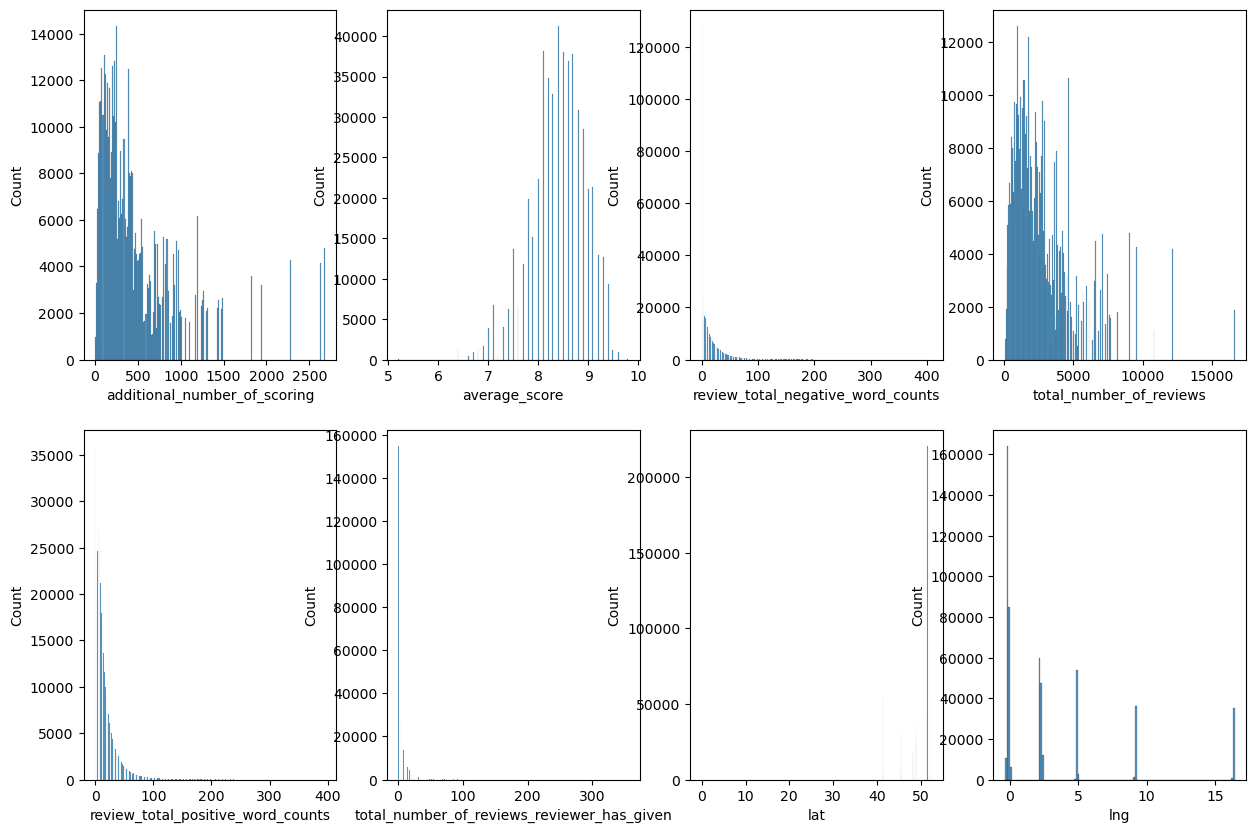

In [32]:
fig, ax = plt.subplots(2,4,figsize=(15, 10))

# Построим графики распределения числовых признаков
half_features = int(len(num)/2) 
for index, value in enumerate(num[0:half_features]):
    plot_num = sns.histplot(data= n_hotels[value],
                            ax= ax[0][index])
    
for index, value in enumerate(num[half_features:]):
    plot_num = sns.histplot(data= n_hotels[value],
                            ax= ax[1][index])

По графикам видно, что в признаках есть аномальные значения

#### Используем метод 3х сигм (метод тьюки) для определения выбросов в числовых признаках

In [33]:
data_cleaner = pd.DataFrame()

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 8) # умнажая iqr на меньшее число, уменьшим диапазон усов (больше очистим)
    # ослабить границы метода Тьюки можно справа или усилить слева и наоборот. 
    upper_bound = quartile_3 + (iqr * 8) 
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    
    data_cleaner[feature] = cleaned[feature]
    return outliers, cleaned

for feature in num:
        outliers, cleaned = outliers_iqr(n_hotels, feature)

In [34]:
data_cleaner.isnull().sum()

additional_number_of_scoring                     0
average_score                                    0
review_total_negative_word_counts             2305
total_number_of_reviews                          0
review_total_positive_word_counts             1432
total_number_of_reviews_reviewer_has_given    2940
lat                                           3268
lng                                              0
sample                                           0
dtype: int64

Внесем полученные очищенные столбцы в датасет

In [35]:
cols_cleaner = list(data_cleaner.columns)
n_hotels[cols_cleaner] = data_cleaner[cols_cleaner]

print(n_hotels.isnull().sum()[num])

additional_number_of_scoring                     0
average_score                                    0
review_total_negative_word_counts             2305
total_number_of_reviews                          0
review_total_positive_word_counts             1432
total_number_of_reviews_reviewer_has_given    2940
lat                                           3268
lng                                              0
sample                                           0
dtype: int64


**Для лаьнейшей работы, предварительно уберем прропуски**

Вариант №1 заполнения медианой

In [36]:
median_fill = {
            'total_number_of_reviews_reviewer_has_given': n_hotels['total_number_of_reviews_reviewer_has_given'].median(),
            'average_score': n_hotels['average_score'].median(),
            'review_total_negative_word_counts': n_hotels['review_total_negative_word_counts'].median(),
            'total_number_of_reviews': n_hotels['total_number_of_reviews'].median(),
            'lat': n_hotels['lat'].median(),
            'lng': n_hotels['lng'].median(),
            'review_total_positive_word_counts': n_hotels['review_total_positive_word_counts'].median(),
            'additional_number_of_scoring':  n_hotels['additional_number_of_scoring'].median()}

n_hotels = n_hotels.fillna(median_fill)

Вариант №2 удалить строки 

In [ ]:
n_hotels = n_hotels.dropna(how='any', axis=0)
print(n_hotels[cols_cleaner].isnull().sum())

#### Разделим данные на выборки (тестовая и обучения)

In [37]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [38]:
X = n_hotels.drop(['reviewer_score'], axis = 1)  
y = n_hotels['reviewer_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
from sklearn.feature_selection import chi2 # хи-квадрат. Максимум 3 признака
# Показывает насколько признаки влияют на один указанный признак

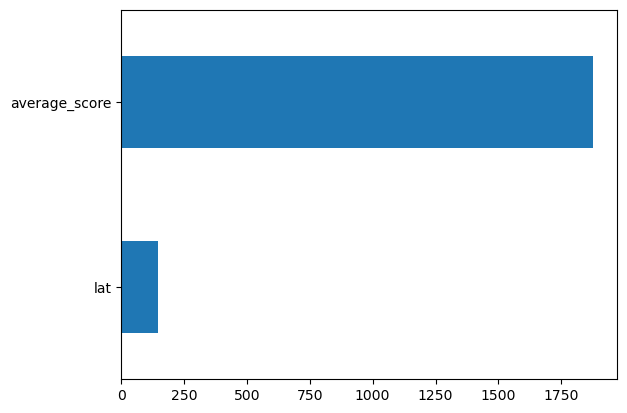

In [40]:
y=y.astype('int') # - Целевой признак, оценка отеля "reviewer_score"

# категориальные признаки (закодированные) признаки, максимум 3
num_cols = ['lat','average_score']

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

По графику важности категориальных признаков мы можем понять, что признак average_score важнее, чем lat, в определении рейтинга отеля:

#### Сравним несколько категориальных признаков для оценки значимости непрерывной переменной "reviewer_score"

In [41]:
from sklearn.feature_selection import f_classif # на основе anova, можно оценить значимость для непрерывных признаков

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


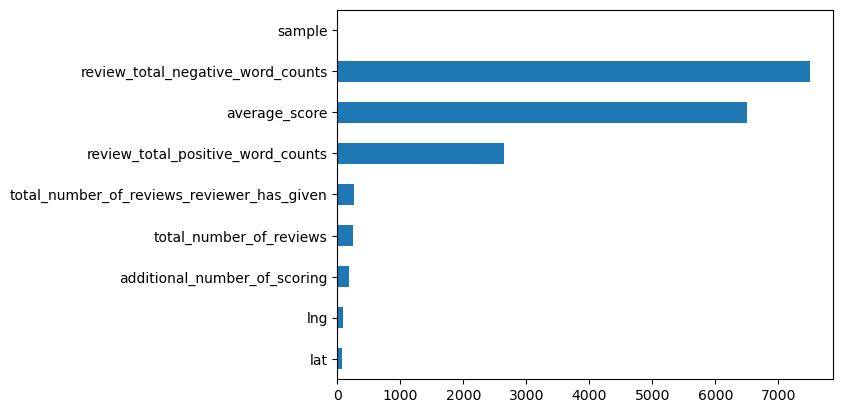

In [42]:
imp_num = pd.Series(f_classif(X[num], y)[0], index = num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

По  графику важности категориальных переменных мы можем понять, что признак review_total_negative_word_counts важнее, чем total_number_of_reviews и average_score, в определении рейтинга отеля

## Закодируем признаки

In [43]:
import category_encoders as ce 
# Для кодирования категорий: Порядковые-ce.OrdinalEncoder(), номинал-OneHotEncoder,бинарного-BinaryEncoder

# Работа с текстовыми данными. Признаки 'positive_review' и 'negative_review'

SentimentIntensityAnalyzer - Модуль позволяет найти интонации в тексте, выяивить негативные/нейтральные/положительные слова

In [44]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [45]:
n_hotels['scores_negative'] = n_hotels['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
n_hotels['scores_positive'] = n_hotels['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))

In [46]:
n_hotels['scores_positive']

0         {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
1         {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...
2         {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...
3         {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
4         {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...
                                ...                        
515733    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515734    {'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'co...
515735    {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'comp...
515736    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515737    {'neg': 0.0, 'neu': 0.458, 'pos': 0.542, 'comp...
Name: scores_positive, Length: 515738, dtype: object

In [47]:
n_hotels['negative_neg'] = n_hotels['scores_negative'].apply(lambda arg: list((arg).values())[0])
n_hotels['negative_neu'] = n_hotels['scores_negative'].apply(lambda arg: list((arg).values())[1])
n_hotels['negative_pos'] = n_hotels['scores_negative'].apply(lambda arg: list((arg).values())[2])
n_hotels['negative_compound'] = n_hotels['scores_negative'].apply(lambda arg: list((arg).values())[-1])

In [48]:
n_hotels['positive_neg'] = n_hotels['scores_positive'].apply(lambda arg: list((arg).values())[0])
n_hotels['positive_neu'] = n_hotels['scores_positive'].apply(lambda arg: list((arg).values())[1])
n_hotels['positive_pos'] = n_hotels['scores_positive'].apply(lambda arg: list((arg).values())[2])
n_hotels['positive_compound'] = n_hotels['scores_positive'].apply(lambda arg: list((arg).values())[-1])

In [49]:
n_hotels['positive_pos']

0         0.329
1         0.621
2         0.740
3         0.379
4         0.770
          ...  
515733    0.000
515734    0.098
515735    0.535
515736    0.000
515737    0.542
Name: positive_pos, Length: 515738, dtype: float64

#### Теперь закодируем остальные признаки

In [50]:
# Признаки для кодировки
cols_binar = ['review_date','hotel_name','reviewer_nationality']

bin_coder = ce.BinaryEncoder(cols=cols_binar)
coding = bin_coder.fit_transform(n_hotels[cols_binar])
display(coding.head(5))

cols_drop = ['hotel_address','tags','review_date','hotel_name','reviewer_nationality']
n_hotels = n_hotels.drop(cols_drop,axis=1)

,review_date_0,review_date_1,review_date_2,review_date_3,review_date_4,review_date_5,review_date_6,review_date_7,review_date_8,review_date_9,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [51]:
n_hotels.head(2)

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,...,scores_negative,scores_positive,negative_neg,negative_neu,negative_pos,negative_compound,positive_neg,positive_neu,positive_pos,positive_compound
0,904,8.1,Would have appreciated a shop in the hotel th...,52.0,16670,Hotel was great clean friendly staff free bre...,62.0,1.0,13 days,45.533137,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,612,8.6,No tissue paper box was present at the room,10.0,5018,No Positive,0.0,7.0,234 day,52.385649,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400


In [52]:
# Полученные Признаки для кодировки
cols_binar = ['year','season']

bin_coder = ce.BinaryEncoder(cols=cols_binar)
coding = bin_coder.fit_transform(n_hotels[cols_binar])
display(coding.head(5))

cols_drop = ['year','season']
n_hotels = n_hotels.drop(cols_drop,axis=1)

,year_0,year_1,season_0,season_1,season_2
0,0,1,0,0,1
1,1,0,0,1,0
2,1,1,0,1,1
3,1,1,0,1,1
4,1,0,1,0,0


In [53]:
def dd(x):
    try:
        return int(str(x)[:3])
    except ValueError:
        return int(str(x)[:2])
     
n_hotels['days_since_review_n'] = n_hotels['days_since_review'].apply(dd)
display(n_hotels['days_since_review_n'])

cols_drop = ['days_since_review']
n_hotels = n_hotels.drop(cols_drop, axis=1)

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review_n, Length: 515738, dtype: int64

### Соединяем закодированные данные и удаляем лишнее

In [54]:
n_hotels = n_hotels.drop(['tags_n','negative_review','positive_review','scores_negative','scores_positive'], axis=1)

In [55]:
n_hotels = pd.concat([n_hotels, coding], axis=1)
display(n_hotels.head(2), n_hotels.shape)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,positive_neg,positive_neu,positive_pos,positive_compound,days_since_review_n,year_0,year_1,season_0,season_1,season_2
0,904,8.1,52.0,16670,62.0,1.0,45.533137,9.171102,0,0.0,...,0.000,0.671,0.329,0.9615,13,0,1,0,0,1
1,612,8.6,10.0,5018,0.0,7.0,52.385649,4.834443,0,0.0,...,0.379,0.000,0.621,0.3400,234,1,0,0,1,0


(515738, 120)

## Строим модель

#### Еще раз разделим данные, но уже подготовленные

In [56]:
# Теперь выделим тестовую часть
train_data = n_hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = n_hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=RANDOM_SEED)

In [58]:
print(X_train.shape, X_test.shape) 
print(y_train.shape, y_test.shape) 
# X_train относится к y_train - таблица и столбец с 75% 

(309442, 118) (77361, 118)
(309442,) (77361,)


In [59]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

In [60]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [61]:
print(y_pred)

[7.944 9.281 8.369 ... 8.696 8.657 9.522]


In [62]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE)
# - показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100)

MAPE: 12.610751114792585


Делаем предсказание по данной в задании выборке

In [63]:
test_data = test_data.drop(['reviewer_score'],axis=1)

In [64]:
predict_submission = regr.predict(test_data)
predict_submission

array([8.403, 7.667, 8.451, ..., 8.246, 9.565, 7.501])

In [65]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [66]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_pred.csv', index=False)
sample_submission

,reviewer_score,id
0,8.403,488440
1,7.667,274649
2,8.451,374688
3,9.752,404352
4,9.436,451596
...,...,...
128930,8.540,495812
128931,9.233,315577
128932,8.246,511968
128933,9.565,303386
